In [1]:
%run ../scripts/notebook_settings.py
import sgkit as sg
import xarray as xr
import glob

First, determine samples to use and gender of the samples. Uses Vasili's cov files.

In [20]:
cov_summaries = glob.glob("/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024/Pan_troglodytes_troglodytes/cov/*")
df_l = []
for p in cov_summaries:
    df = pd.read_csv(p, sep="\t", names=["Name", "Contig", "start", "end", "length", "?", "coverage"])
    df["ID"] = p.split("/")[-1].split(".")[0]
    df_l.append(df)
df_cov = pd.concat(df_l)

In [21]:
df_cov["Contig_type"] = ["chrX" if x == "postPAR1" else "non-X" for x in df_cov.Name]
df_group = df_cov.groupby(["ID", "Contig_type"])["coverage"].median().reset_index()
non_X = df_group.loc[df_group.Contig_type == "non-X"]
df_cov["aut_cov"] = df_cov.ID.map(dict(zip(non_X.ID, non_X.coverage)))
df_cov["relative_cov"] = df_cov.coverage/df_cov.aut_cov

Use this df to create two sample cohorts, male and female.

In [22]:
df_x_only = df_cov.loc[df_cov.Contig_type == "chrX"]
df_x_only["Sex"] = [0 if x <= 0.75 else 1 for x in df_x_only.relative_cov]

/tmp/61596253/ipykernel_3366465/1432902879.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x_only["Sex"] = [0 if x <= 0.75 else 1 for x in df_x_only.relative_cov]


In [23]:
ds = sg.load_dataset("../data/Pan_troglodytes_troglodytes")
ds["sample_cohort"] = xr.DataArray(pd.Series(ds.sample_id.values).map(dict(zip(df_x_only.ID,df_x_only.Sex
                                                                              ))), dims="samples")

In [24]:
pd.Series(ds["variant_contig"]).unique() #unique or value_counts to determine contigs with data in them.

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int8)

In [25]:
ds

<xarray.Dataset> Size: 4GB
Dimensions:               (variants: 30208269, samples: 18, ploidy: 2,
                           contigs: 26, filters: 2, region_index_values: 30232,
                           region_index_fields: 6, alleles: 2)
Coordinates:
  * samples               (samples) int64 144B 0 1 2 3 4 5 ... 12 13 14 15 16 17
Dimensions without coordinates: variants, ploidy, contigs, filters,
                                region_index_values, region_index_fields,
                                alleles
Data variables: (12/17)
    call_genotype         (variants, samples, ploidy) int8 1GB dask.array<chunksize=(1000, 18, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool 1GB dask.array<chunksize=(1000, 18, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool 544MB dask.array<chunksize=(1000, 18), meta=np.ndarray>
    contig_id             (contigs) object 208B dask.array<chunksize=(26,), meta=np.ndarray>
    contig_length         (contigs) float64 208B dask.array<chunksize=(26,), meta=np.ndarray>
    filter_id             (filters) object 16B dask.array<chunksize=(2,), meta=np.ndarray>
    ...                    ...
    variant_id            (variants) object 242MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_id_mask       (variants) bool 30MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length        (variants) int16 60MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_position      (variants) int32 121MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality       (variants) float32 121MB dask.array<chunksize=(1000,), meta=np.ndarray>
    sample_cohort         (samples) int64 144B 1 1 1 1 0 1 1 1 ... 0 0 0 0 1 1 1
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [26]:
missing_rate = ds.call_genotype_mask[:,:,0].sum(axis=0).values/ds.call_genotype_mask[:,:,0].count(axis=0).values

In [27]:
missing_rate

array([0.02458079, 0.02546938, 0.02514937, 0.08372065, 0.05321139,
       0.57596137, 0.02527222, 0.01335383, 0.06575203, 0.01345281,
       0.06196171, 0.03679158, 0.01839132, 0.01302355, 0.05359811,
       0.09261216, 0.26603153, 0.34774836])

In [28]:
df_x_only

,Name,Contig,start,end,length,?,coverage,ID,Contig_type,aut_cov,relative_cov,Sex
25,postPAR1,NC_072421.2,3170189,153896354,150454157,2640324019,17.5490,SAMEA4374775,chrX,18.52710,0.947207,1
9,postPAR1,NC_072421.2,3170189,153896354,150435734,3646950692,24.2426,SAMEA4374772,chrX,25.09210,0.966145,1
53,postPAR1,NC_072421.2,3170189,153896354,150435521,3646249577,24.2380,SAMEA4374772,chrX,25.09210,0.965961,1
9,postPAR1,NC_072421.2,3170189,153896354,150309621,3153251237,20.9784,SAMEA4374780,chrX,23.04640,0.910268,1
53,postPAR1,NC_072421.2,3170189,153896354,150308435,3152336341,20.9725,SAMEA4374780,chrX,23.04640,0.910012,1
9,postPAR1,NC_072421.2,3170189,153896354,149927874,3387379799,22.5934,SAMN01920534,chrX,23.49255,0.961726,1
53,postPAR1,NC_072421.2,3170189,153896354,149928563,3386483967,22.5873,SAMN01920534,chrX,23.49255,0.961467,1
9,postPAR1,NC_072421.2,3170189,153896354,149394439,2038453877,13.6448,SAMN01920533,chrX,28.38500,0.480705,0
53,postPAR1,NC_072421.2,3170189,153896354,149396933,2037693309,13.6395,SAMN01920533,chrX,28.38500,0.480518,0
9,postPAR1,NC_072421.2,3170189,153896354,150530239,3203464820,21.2812,SAMEA4374773,chrX,24.09465,0.883233,1


In [36]:
ds.sample_id.values

array(['SAMEA4374770', 'SAMEA4374771', 'SAMEA4374772', 'SAMEA4374773',
       'SAMEA4374774', 'SAMEA4374775', 'SAMEA4374776', 'SAMEA4374777',
       'SAMEA4374778', 'SAMEA4374779', 'SAMEA4374780', 'SAMEA4374781',
       'SAMEA4374782', 'SAMEA4374785', 'SAMN01920533', 'SAMN01920534',
       'SAMN01920535', 'SAMN01920536'], dtype=object)

In [37]:
df_x_only.loc[df_x_only.ID.isin(ds.sample_id.values)]

,Name,Contig,start,end,length,?,coverage,ID,Contig_type,aut_cov,relative_cov,Sex
25,postPAR1,NC_072421.2,3170189,153896354,150454157,2640324019,17.5490,SAMEA4374775,chrX,18.52710,0.947207,1
9,postPAR1,NC_072421.2,3170189,153896354,150435734,3646950692,24.2426,SAMEA4374772,chrX,25.09210,0.966145,1
53,postPAR1,NC_072421.2,3170189,153896354,150435521,3646249577,24.2380,SAMEA4374772,chrX,25.09210,0.965961,1
9,postPAR1,NC_072421.2,3170189,153896354,150309621,3153251237,20.9784,SAMEA4374780,chrX,23.04640,0.910268,1
53,postPAR1,NC_072421.2,3170189,153896354,150308435,3152336341,20.9725,SAMEA4374780,chrX,23.04640,0.910012,1
9,postPAR1,NC_072421.2,3170189,153896354,149927874,3387379799,22.5934,SAMN01920534,chrX,23.49255,0.961726,1
53,postPAR1,NC_072421.2,3170189,153896354,149928563,3386483967,22.5873,SAMN01920534,chrX,23.49255,0.961467,1
9,postPAR1,NC_072421.2,3170189,153896354,149394439,2038453877,13.6448,SAMN01920533,chrX,28.38500,0.480705,0
53,postPAR1,NC_072421.2,3170189,153896354,149396933,2037693309,13.6395,SAMN01920533,chrX,28.38500,0.480518,0
9,postPAR1,NC_072421.2,3170189,153896354,150530239,3203464820,21.2812,SAMEA4374773,chrX,24.09465,0.883233,1


[Text(0, 0.5, 'Missing Rate'), Text(0.5, 0, 'Autosomal Coverage')]

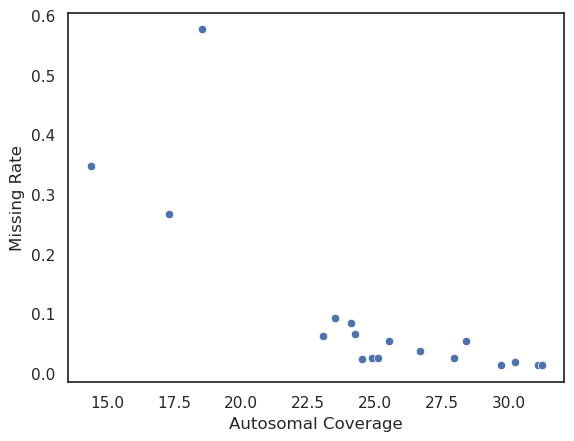

In [39]:
g = sns.scatterplot(y=missing_rate,
                x=df_x_only.loc[df_x_only.ID.isin(ds.sample_id.values)].drop_duplicates("ID").sort_values(by="ID").aut_cov)
g.set(ylabel="Missing Rate", xlabel="Autosomal Coverage")

In [40]:
test_df = pd.DataFrame({"Missing": missing_rate,
               "Aut_cov": df_x_only.loc[df_x_only.ID.isin(ds.sample_id.values)].drop_duplicates("ID").sort_values(by="ID").aut_cov,
             "ID": ds.sample_id.values}).sort_values(by="Aut_cov")

In [43]:
test_df["Seq_line"] = ["PD" if x[:1]=="P" else "SAM" for x in test_df.ID]

[Text(0, 0.5, 'Missing Rate'), Text(0.5, 0, 'Autosomal Coverage')]

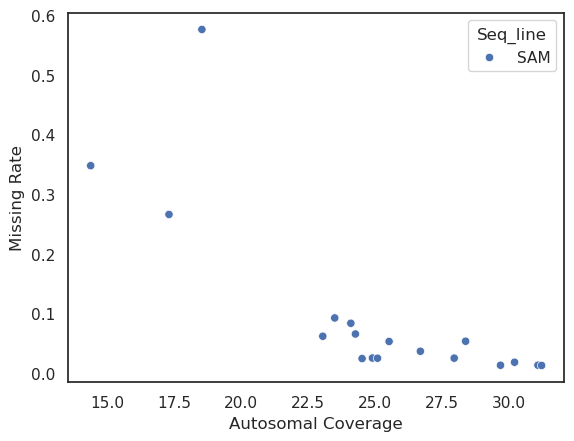

In [44]:
g = sns.scatterplot(test_df, y="Missing", x="Aut_cov", hue="Seq_line")
g.set(ylabel="Missing Rate", xlabel="Autosomal Coverage")

In [45]:
# Step to handle my issues - remove empty contigs, that is contigs without any variants.
dstest = ds.sel(contigs=pd.Series(ds["variant_contig"]).unique())
IDs_to_keep = df_x_only.loc[df_x_only.aut_cov >= 20].ID
df_i_ID = pd.DataFrame({"ds_index": ds.samples, "ID": ds.sample_id})
dstest = dstest.sel(samples=df_i_ID.loc[df_i_ID.ID.isin(IDs_to_keep)].ds_index.values)

In [46]:
dstest

<xarray.Dataset> Size: 3GB
Dimensions:               (variants: 30208269, samples: 15, ploidy: 2,
                           contigs: 24, filters: 2, region_index_values: 30232,
                           region_index_fields: 6, alleles: 2)
Coordinates:
  * samples               (samples) int64 120B 0 1 2 3 4 6 ... 10 11 12 13 14 15
Dimensions without coordinates: variants, ploidy, contigs, filters,
                                region_index_values, region_index_fields,
                                alleles
Data variables: (12/17)
    call_genotype         (variants, samples, ploidy) int8 906MB dask.array<chunksize=(1000, 15, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool 906MB dask.array<chunksize=(1000, 15, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool 453MB dask.array<chunksize=(1000, 15), meta=np.ndarray>
    contig_id             (contigs) object 192B dask.array<chunksize=(24,), meta=np.ndarray>
    contig_length         (contigs) float64 192B dask.array<chunksize=(24,), meta=np.ndarray>
    filter_id             (filters) object 16B dask.array<chunksize=(2,), meta=np.ndarray>
    ...                    ...
    variant_id            (variants) object 242MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_id_mask       (variants) bool 30MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length        (variants) int16 60MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_position      (variants) int32 121MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality       (variants) float32 121MB dask.array<chunksize=(1000,), meta=np.ndarray>
    sample_cohort         (samples) int64 120B 1 1 1 1 0 1 1 1 1 1 0 0 0 0 1
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [47]:
# Going to use 10000 position windows as filtering is not that easy without a coverage map.
window_size = 5000
ds_w = sg.window_by_position(dstest, size=window_size)
ds_d = sg.diversity(ds_w) # It crashes on very large windows, but works in the 1k-10k range.

In [48]:
# Note how I generate a new coordinate to filter/plot by, and make sure to add the relevant dimensions to it.
window_starts_bp = pd.DataFrame({"window_contig":ds_d.window_contig}).groupby("window_contig").cumcount().values*window_size
ds_d["w_s_bp"] = (["windows"], window_starts_bp)
ds_d

<xarray.Dataset> Size: 5GB
Dimensions:               (windows: 627803, cohorts: 2, variants: 30208269,
                           alleles: 2, samples: 15, ploidy: 2, contigs: 24,
                           filters: 2, region_index_values: 30232,
                           region_index_fields: 6)
Coordinates:
  * samples               (samples) int64 120B 0 1 2 3 4 6 ... 10 11 12 13 14 15
Dimensions without coordinates: windows, cohorts, variants, alleles, ploidy,
                                contigs, filters, region_index_values,
                                region_index_fields
Data variables: (12/24)
    stat_diversity        (windows, cohorts) float64 10MB dask.array<chunksize=(56, 2), meta=np.ndarray>
    cohort_allele_count   (variants, cohorts, alleles) uint64 967MB dask.array<chunksize=(1000, 2, 2), meta=np.ndarray>
    call_allele_count     (variants, samples, alleles) uint8 906MB dask.array<chunksize=(1000, 15, 2), meta=np.ndarray>
    window_contig         (windows) int64 5MB 0 0 0 0 0 0 ... 23 23 23 23 23 23
    window_start          (windows) int64 5MB 0 0 0 ... 30208267 30208268
    window_stop           (windows) int64 5MB 0 0 0 ... 30208268 30208269
    ...                    ...
    variant_id_mask       (variants) bool 30MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length        (variants) int16 60MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_position      (variants) int32 121MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality       (variants) float32 121MB dask.array<chunksize=(1000,), meta=np.ndarray>
    sample_cohort         (samples) int64 120B 1 1 1 1 0 1 1 1 1 1 0 0 0 0 1
    w_s_bp                (windows) int64 5MB 0 5000 ... 153775000 153780000
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [49]:
ds_d

<xarray.Dataset> Size: 5GB
Dimensions:               (windows: 627803, cohorts: 2, variants: 30208269,
                           alleles: 2, samples: 15, ploidy: 2, contigs: 24,
                           filters: 2, region_index_values: 30232,
                           region_index_fields: 6)
Coordinates:
  * samples               (samples) int64 120B 0 1 2 3 4 6 ... 10 11 12 13 14 15
Dimensions without coordinates: windows, cohorts, variants, alleles, ploidy,
                                contigs, filters, region_index_values,
                                region_index_fields
Data variables: (12/24)
    stat_diversity        (windows, cohorts) float64 10MB dask.array<chunksize=(56, 2), meta=np.ndarray>
    cohort_allele_count   (variants, cohorts, alleles) uint64 967MB dask.array<chunksize=(1000, 2, 2), meta=np.ndarray>
    call_allele_count     (variants, samples, alleles) uint8 906MB dask.array<chunksize=(1000, 15, 2), meta=np.ndarray>
    window_contig         (windows) int64 5MB 0 0 0 0 0 0 ... 23 23 23 23 23 23
    window_start          (windows) int64 5MB 0 0 0 ... 30208267 30208268
    window_stop           (windows) int64 5MB 0 0 0 ... 30208268 30208269
    ...                    ...
    variant_id_mask       (variants) bool 30MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length        (variants) int16 60MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_position      (variants) int32 121MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality       (variants) float32 121MB dask.array<chunksize=(1000,), meta=np.ndarray>
    sample_cohort         (samples) int64 120B 1 1 1 1 0 1 1 1 1 1 0 0 0 0 1
    w_s_bp                (windows) int64 5MB 0 5000 ... 153775000 153780000
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [50]:
ds_vi = ds_d.set_index(variants=("variant_contig", "variant_position"))

In [51]:
div_stats_x = ds_vi.sel(variant_contig = 23)["stat_diversity"].values

[(-1.0, 75.0), Text(0.5, 1.0, 'Diversity per 10k')]

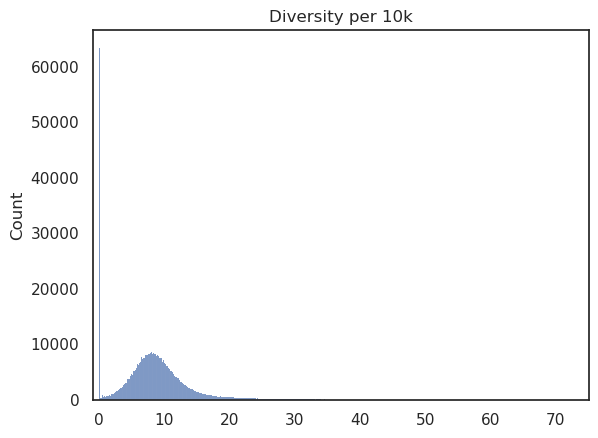

In [52]:
g = sns.histplot(div_stats_x[:,0])
g.set(xlim=(-1, 75), title="Diversity per 10k")

<Axes: ylabel='Count'>

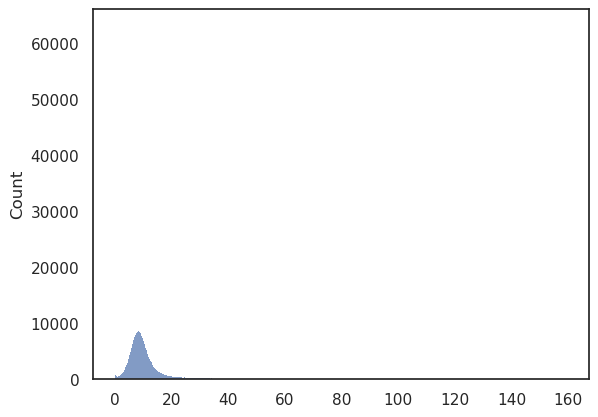

In [53]:
sns.histplot(div_stats_x[:,1])

In [54]:
ds_vi

<xarray.Dataset> Size: 6GB
Dimensions:               (windows: 627803, cohorts: 2, variants: 30208269,
                           alleles: 2, samples: 15, ploidy: 2, contigs: 24,
                           filters: 2, region_index_values: 30232,
                           region_index_fields: 6)
Coordinates:
  * samples               (samples) int64 120B 0 1 2 3 4 6 ... 10 11 12 13 14 15
  * variants              (variants) object 242MB MultiIndex
  * variant_contig        (variants) int8 30MB 0 0 0 0 0 0 ... 23 23 23 23 23 23
  * variant_position      (variants) int32 121MB 163728 163789 ... 153783057
Dimensions without coordinates: windows, cohorts, alleles, ploidy, contigs,
                                filters, region_index_values,
                                region_index_fields
Data variables: (12/22)
    stat_diversity        (windows, cohorts) float64 10MB dask.array<chunksize=(56, 2), meta=np.ndarray>
    cohort_allele_count   (variants, cohorts, alleles) uint64 967MB dask.array<chunksize=(1000, 2, 2), meta=np.ndarray>
    call_allele_count     (variants, samples, alleles) uint8 906MB dask.array<chunksize=(1000, 15, 2), meta=np.ndarray>
    window_contig         (windows) int64 5MB 0 0 0 0 0 0 ... 23 23 23 23 23 23
    window_start          (windows) int64 5MB 0 0 0 ... 30208267 30208268
    window_stop           (windows) int64 5MB 0 0 0 ... 30208268 30208269
    ...                    ...
    variant_id            (variants) object 242MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_id_mask       (variants) bool 30MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length        (variants) int16 60MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality       (variants) float32 121MB dask.array<chunksize=(1000,), meta=np.ndarray>
    sample_cohort         (samples) int64 120B 1 1 1 1 0 1 1 1 1 1 0 0 0 0 1
    w_s_bp                (windows) int64 5MB 0 5000 ... 153775000 153780000
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [55]:
np.nanmean(div_stats_x[:,1]), np.nanmean(div_stats_x[:,0]) # Females have a marginally higher diversity, but very similar

(8.747890246330021, 8.604657735808944)

In [56]:
# Code from the sgkit reference to find the variants that are in each window.
size_l = pd.Series([j-i for i, j in zip(ds_d.window_start[:].values,
                             ds_d.window_stop[:].values)])
# Very slow, but I do not need to extract the exact variants. Difference between index start and end is enough.
# And this is quick.

[Text(0.5, 1.0, 'Variants per window')]

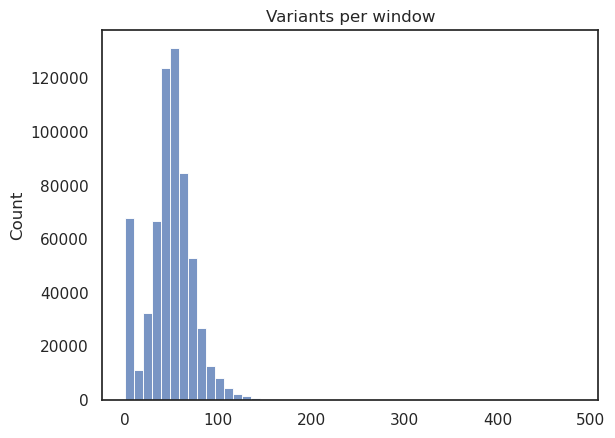

In [57]:
g = sns.histplot(size_l, bins=50)
g.set(title="Variants per window")

In [58]:
size_l.mean(), size_l.median(), size_l.quantile(0.2)

(48.11743333497928, 49.0, 32.0)

Subsetting to only use windows with at least 10 sites.
Determining whether diversity correlation is similar on chrX and autosomes across male/females.

In [59]:
ds_sites = ds_d.sel(windows = (size_l >= 10))
ds_sites = ds_sites.set_index(variants=("variant_contig", "variant_position"))

In [60]:
ds_sites

<xarray.Dataset> Size: 6GB
Dimensions:               (windows: 560049, cohorts: 2, variants: 30208269,
                           alleles: 2, samples: 15, ploidy: 2, contigs: 24,
                           filters: 2, region_index_values: 30232,
                           region_index_fields: 6)
Coordinates:
  * samples               (samples) int64 120B 0 1 2 3 4 6 ... 10 11 12 13 14 15
  * variants              (variants) object 242MB MultiIndex
  * variant_contig        (variants) int8 30MB 0 0 0 0 0 0 ... 23 23 23 23 23 23
  * variant_position      (variants) int32 121MB 163728 163789 ... 153783057
Dimensions without coordinates: windows, cohorts, alleles, ploidy, contigs,
                                filters, region_index_values,
                                region_index_fields
Data variables: (12/22)
    stat_diversity        (windows, cohorts) float64 9MB dask.array<chunksize=(20, 2), meta=np.ndarray>
    cohort_allele_count   (variants, cohorts, alleles) uint64 967MB dask.array<chunksize=(1000, 2, 2), meta=np.ndarray>
    call_allele_count     (variants, samples, alleles) uint8 906MB dask.array<chunksize=(1000, 15, 2), meta=np.ndarray>
    window_contig         (windows) int64 4MB 0 0 0 0 0 0 ... 23 23 23 23 23 23
    window_start          (windows) int64 4MB 2 28 89 ... 30208227 30208255
    window_stop           (windows) int64 4MB 28 89 134 ... 30208255 30208265
    ...                    ...
    variant_id            (variants) object 242MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_id_mask       (variants) bool 30MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length        (variants) int16 60MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality       (variants) float32 121MB dask.array<chunksize=(1000,), meta=np.ndarray>
    sample_cohort         (samples) int64 120B 1 1 1 1 0 1 1 1 1 1 0 0 0 0 1
    w_s_bp                (windows) int64 4MB 180000 185000 ... 153750000
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

Diversity comparison before and after this filter.

[Text(0.5, 1.0, 'Pi per base in 10k windows')]

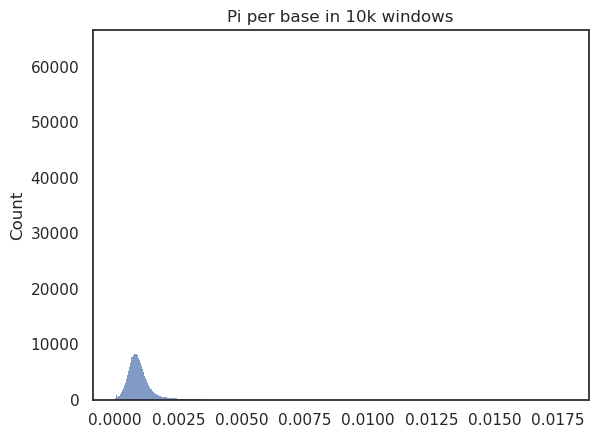

In [61]:
g = sns.histplot(ds_d["stat_diversity"][:,0]/10000)
g.set(title="Pi per base in 10k windows")

[Text(0.5, 1.0, 'Pi per base in 10k windows')]

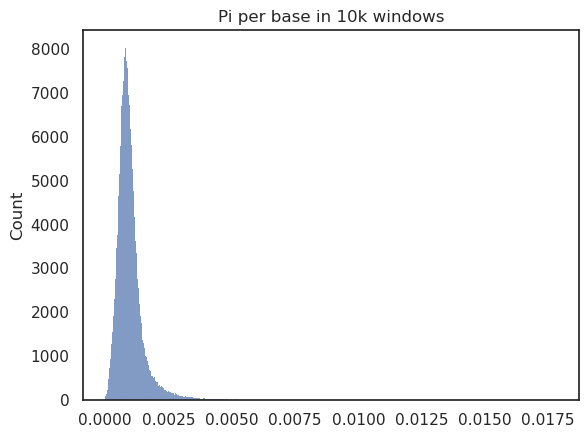

In [62]:
g = sns.histplot(ds_sites["stat_diversity"][:,0]/10000)
g.set(title="Pi per base in 10k windows")

In [63]:
df = pd.DataFrame()
for c in [13, 14, 15, 23]:
    ds_s = ds_sites.sel(variant_contig=(c))
    ds_s = ds_s.sel(contigs=(c))
    ds_s = ds_s.sel(variant_position=slice(12039749, None))
    ds_s = sg.individual_heterozygosity(ds_s)
    total_het = ds_s["call_heterozygosity"].sum(axis=0).values
    df["contig_{}_total_het".format(c)] = total_het
    df["het_per_basepair_{}".format(c)] = total_het/int(ds_s["contig_length"].values)
    df["het_per_called_site_{}".format(c)] = total_het/len(ds_s["call_heterozygosity"])

/home/eriks/miniconda3/envs/primatediversity2/lib/python3.12/site-packages/sgkit/utils.py:151: DimensionWarning: Dimensions ('variant_position', 'samples', 'alleles') do not match ('variants', 'samples', 'alleles')
  warnings.warn(f"Dimensions {a.dims} do not match {dims}", DimensionWarning)
/home/eriks/miniconda3/envs/primatediversity2/lib/python3.12/site-packages/sgkit/utils.py:151: DimensionWarning: Dimensions ('variant_position', 'samples', 'alleles') do not match ('variants', 'samples', 'alleles')
  warnings.warn(f"Dimensions {a.dims} do not match {dims}", DimensionWarning)
/home/eriks/miniconda3/envs/primatediversity2/lib/python3.12/site-packages/sgkit/utils.py:151: DimensionWarning: Dimensions ('variant_position', 'samples', 'alleles') do not match ('variants', 'samples', 'alleles')
  warnings.warn(f"Dimensions {a.dims} do not match {dims}", DimensionWarning)
/home/eriks/miniconda3/envs/primatediversity2/lib/python3.12/site-packages/sgkit/utils.py:151: DimensionWarning: Dimensio

<Axes: xlabel='het_per_basepair_14', ylabel='X_12_ratio'>

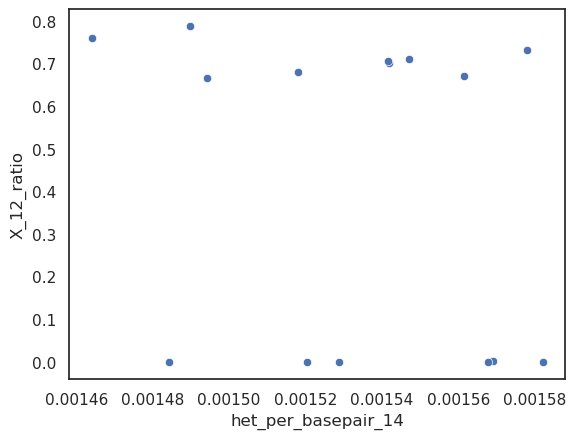

In [64]:
df["X_12_ratio"] = df["het_per_basepair_23"]/df["het_per_basepair_13"]
df["ID"] = ds_s.sample_id.values
#df["relative_cov"] = df.ID.map(dict(zip(x_cov_determination.ID, x_cov_determination.relative_cov)))
sns.scatterplot(df, y="X_12_ratio", x="het_per_basepair_14")

In [65]:
dict(zip(df_x_only.ID,df_x_only.Sex))

{'SAMEA4374775': 1,
 'SAMEA4374772': 1,
 'SAMEA4374780': 1,
 'SAMN01920534': 1,
 'SAMN01920533': 0,
 'SAMEA4374773': 1,
 'SAMEA4374774': 0,
 'SAMEA4374781': 0,
 'SAMN01920535': 1,
 'SAMEA4374782': 0,
 'SAMN01920536': 1,
 'SAMEA4374785': 0,
 'SAMEA4374779': 1,
 'SAMEA4374777': 1,
 'SAMEA4374770': 1,
 'SAMEA4374771': 1,
 'SAMEA4374776': 1,
 'SAMEA4374778': 1}

Checking correlation between maleX and femaleX. The number of windows are correct (I would imagine), but the positions are odd. It's index positions.

In [66]:
ds_sitesX = ds_sites.sel(windows=(ds_sites.window_contig == 23))

In [67]:
ds_sitesX

<xarray.Dataset> Size: 6GB
Dimensions:               (windows: 29234, cohorts: 2, variants: 30208269,
                           alleles: 2, samples: 15, ploidy: 2, contigs: 24,
                           filters: 2, region_index_values: 30232,
                           region_index_fields: 6)
Coordinates:
  * samples               (samples) int64 120B 0 1 2 3 4 6 ... 10 11 12 13 14 15
  * variants              (variants) object 242MB MultiIndex
  * variant_contig        (variants) int8 30MB 0 0 0 0 0 0 ... 23 23 23 23 23 23
  * variant_position      (variants) int32 121MB 163728 163789 ... 153783057
Dimensions without coordinates: windows, cohorts, alleles, ploidy, contigs,
                                filters, region_index_values,
                                region_index_fields
Data variables: (12/22)
    stat_diversity        (windows, cohorts) float64 468kB dask.array<chunksize=(19, 2), meta=np.ndarray>
    cohort_allele_count   (variants, cohorts, alleles) uint64 967MB dask.array<chunksize=(1000, 2, 2), meta=np.ndarray>
    call_allele_count     (variants, samples, alleles) uint8 906MB dask.array<chunksize=(1000, 15, 2), meta=np.ndarray>
    window_contig         (windows) int64 234kB 23 23 23 23 23 ... 23 23 23 23
    window_start          (windows) int64 234kB 29174982 29175014 ... 30208255
    window_stop           (windows) int64 234kB 29174993 29175079 ... 30208265
    ...                    ...
    variant_id            (variants) object 242MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_id_mask       (variants) bool 30MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length        (variants) int16 60MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality       (variants) float32 121MB dask.array<chunksize=(1000,), meta=np.ndarray>
    sample_cohort         (samples) int64 120B 1 1 1 1 0 1 1 1 1 1 0 0 0 0 1
    w_s_bp                (windows) int64 234kB 30000 695000 ... 153750000
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [68]:
len(ds_sitesX.window_contig)

29234

[Text(0.5, 1.0, 'Male chrX diversity'),
 Text(0, 0.5, 'Pi'),
 Text(0.5, 0, 'Window')]

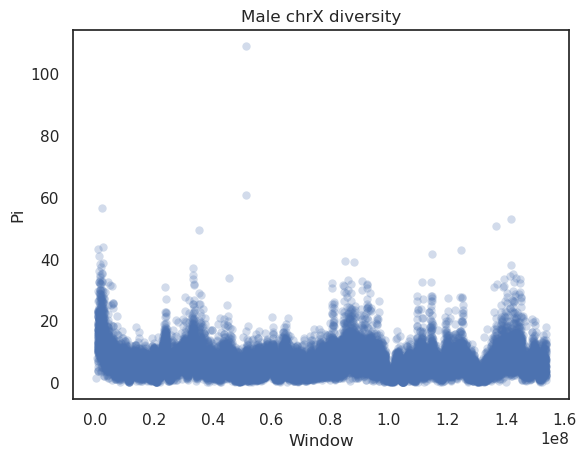

In [69]:
g = sns.scatterplot(x=ds_sitesX.w_s_bp, y=ds_sitesX.stat_diversity[:,0], alpha=0.25, linewidth=0)
g.set(title="Male chrX diversity", ylabel="Pi", xlabel="Window")

[Text(0.5, 1.0, 'Female chrX diversity'),
 Text(0, 0.5, 'Pi'),
 Text(0.5, 0, 'Window')]

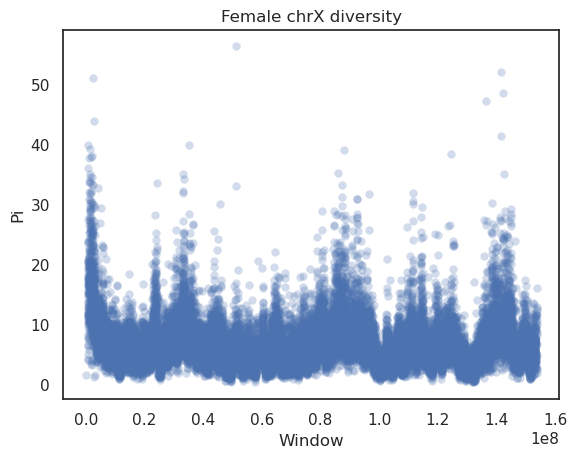

In [70]:
g = sns.scatterplot(x=ds_sitesX.w_s_bp, y=ds_sitesX.stat_diversity[:,1], alpha=0.25, linewidth=0)
g.set(title="Female chrX diversity", ylabel="Pi", xlabel="Window")

<Axes: ylabel='Count'>

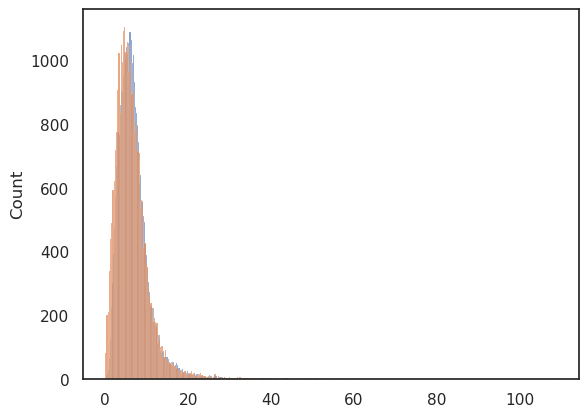

In [71]:
sns.histplot(ds_sitesX.stat_diversity[:,1])
sns.histplot(ds_sitesX.stat_diversity[:,0])

In [72]:
(ds_sitesX.stat_diversity[:,1].mean()/ds_sitesX.stat_diversity[:,0].mean()).values

array(1.069958)

Runs of low diversity.

In [73]:
import itertools
diversity_df = pd.DataFrame({"window_start": ds_sitesX.w_s_bp, "diversity": ds_sitesX.stat_diversity[:,1]})
diversity_df["low_cut"] = diversity_df.diversity < np.quantile(ds_sitesX.stat_diversity[:,1].values, 0.5)
diversity_df["low_streak"] = [i for k, g in itertools.groupby(diversity_df["low_cut"]) for i in range(len(list(g)))]


[Text(0.5, 1.0, 'Female chrX low diversity runs'),
 Text(0, 0.5, 'Run Length'),
 Text(0.5, 0, 'Window')]

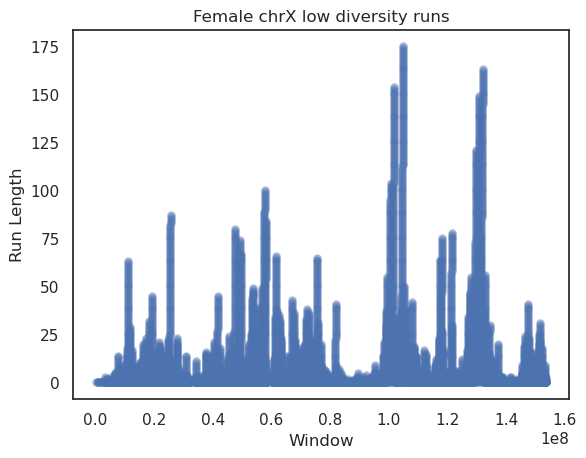

In [74]:
g = sns.scatterplot(diversity_df.loc[diversity_df.low_cut == True], x="window_start", y="low_streak", alpha=0.5, linewidth=0)
g.set(title="Female chrX low diversity runs", ylabel="Run Length", xlabel="Window")

In [75]:
diversity_df.loc[diversity_df.low_cut == True].sort_values(by="low_streak")

,window_start,diversity,low_cut,low_streak
0,30000,1.603428,True,0
14119,75120000,3.130753,True,0
14117,75110000,5.067853,True,0
14114,75095000,5.885449,True,0
14112,75085000,5.510148,True,0
...,...,...,...,...
19977,104970000,4.378630,True,171
19978,104975000,3.850017,True,172
19979,104980000,4.382697,True,173
19980,104985000,6.030874,True,174


Garuds H.

In [76]:
ds_garud = sg.Garud_H(ds_sitesX)

[Text(0.5, 1.0, "Female chrX Garud's H12"),
 Text(0, 0.5, 'Percentage haplotypes'),
 Text(0.5, 0, 'Window')]

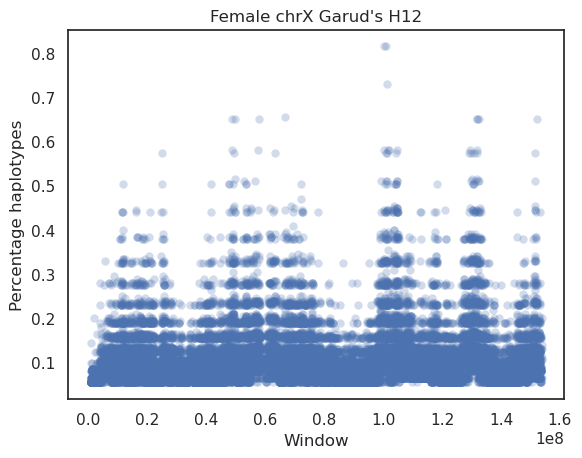

In [77]:
g = sns.scatterplot(x=ds_garud.w_s_bp[1:], y=ds_garud.stat_Garud_h12[:len(ds_garud.stat_Garud_h12)-1,1].values, alpha=0.25, linewidth=0)
g.set(title="Female chrX Garud's H12", ylabel="Percentage haplotypes", xlabel="Window")

In [78]:
ds_sites.sel(windows=(ds_sites.window_start <= 1000))

<xarray.Dataset> Size: 6GB
Dimensions:               (windows: 20, cohorts: 2, variants: 30208269,
                           alleles: 2, samples: 15, ploidy: 2, contigs: 24,
                           filters: 2, region_index_values: 30232,
                           region_index_fields: 6)
Coordinates:
  * samples               (samples) int64 120B 0 1 2 3 4 6 ... 10 11 12 13 14 15
  * variants              (variants) object 242MB MultiIndex
  * variant_contig        (variants) int8 30MB 0 0 0 0 0 0 ... 23 23 23 23 23 23
  * variant_position      (variants) int32 121MB 163728 163789 ... 153783057
Dimensions without coordinates: windows, cohorts, alleles, ploidy, contigs,
                                filters, region_index_values,
                                region_index_fields
Data variables: (12/22)
    stat_diversity        (windows, cohorts) float64 320B dask.array<chunksize=(20, 2), meta=np.ndarray>
    cohort_allele_count   (variants, cohorts, alleles) uint64 967MB dask.array<chunksize=(1000, 2, 2), meta=np.ndarray>
    call_allele_count     (variants, samples, alleles) uint8 906MB dask.array<chunksize=(1000, 15, 2), meta=np.ndarray>
    window_contig         (windows) int64 160B 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    window_start          (windows) int64 160B 2 28 89 134 ... 800 846 920 973
    window_stop           (windows) int64 160B 28 89 134 180 ... 920 973 1023
    ...                    ...
    variant_id            (variants) object 242MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_id_mask       (variants) bool 30MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length        (variants) int16 60MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality       (variants) float32 121MB dask.array<chunksize=(1000,), meta=np.ndarray>
    sample_cohort         (samples) int64 120B 1 1 1 1 0 1 1 1 1 1 0 0 0 0 1
    w_s_bp                (windows) int64 160B 180000 185000 ... 270000 275000
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [79]:
ds_sites_aut = ds_sites.sel(windows=(ds_sites.window_contig != 23))

In [80]:
xr.corr(ds_sitesX.stat_diversity[:,1], ds_sitesX.stat_diversity[:,0]).values

array(0.85004969)

Brainstorm other statistics to present. Lets do some relatedness statistics.

In [81]:
c_chosen = 10
ds10 = dstest.sel(variants=(dstest.variant_contig == 10).compute())

<Axes: >

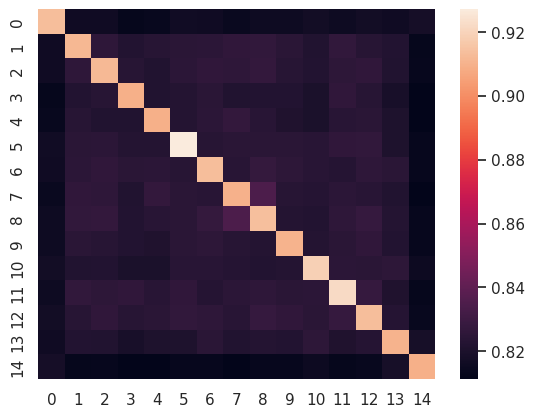

In [82]:
sns.heatmap(sg.identity_by_state(ds10)["stat_identity_by_state"].values)

In [83]:
ids_square = sg.identity_by_state(ds10)["stat_identity_by_state"].values

<Axes: ylabel='Count'>

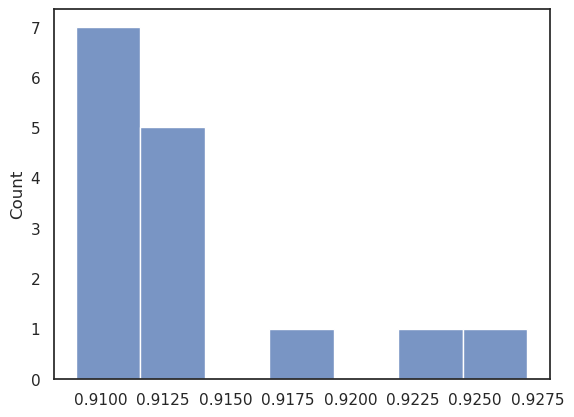

In [84]:
sns.histplot(ids_square.diagonal())

<Axes: ylabel='Count'>

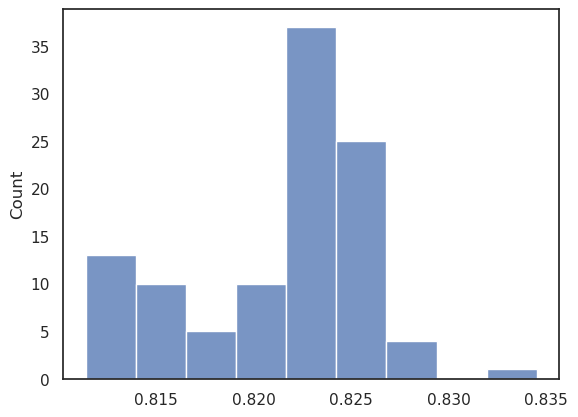

In [85]:
sns.histplot(ids_square[np.tril_indices(len(ids_square), -1)])

In [86]:
missing_rate = ds10.call_genotype_mask[:,:,1].sum(axis=1).values/ds10.call_genotype_mask[:,:,1].count(axis=1).values
ds10ss = ds10.isel(variants=(missing_rate == 0))

In [87]:
ds10ss["call_dosage"] = ds10ss["call_genotype"].sum(dim="ploidy")

<Axes: ylabel='Count'>

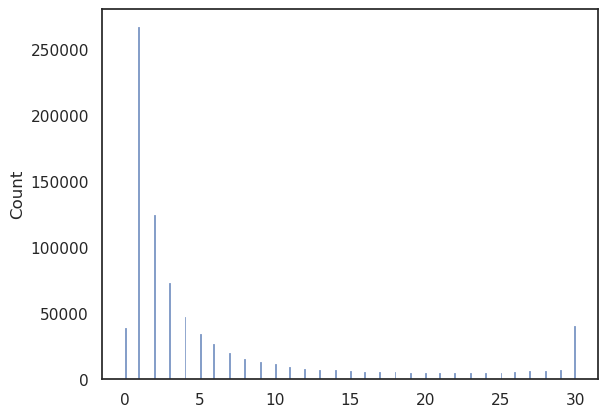

In [88]:
sns.histplot(ds10ss.call_dosage.sum(axis=1))

In [90]:
ds10ss["call_dosage"] = ds10ss["call_genotype"].sum(dim="ploidy")
ds10ss = ds10ss.isel(variants=((ds10ss.call_dosage.sum(axis=1).values >= 4)
                               & (ds10ss.call_dosage.sum(axis=1).values <= 26)))
ds10ss = sg.window_by_variant(ds10ss, size=100)
pruned_ds = sg.ld_prune(ds10ss)
pca10 = sg.pca(pruned_ds)

[Text(0.5, 0, 'PC1, Variance explained 0.0868'),
 Text(0, 0.5, 'PC2, Variance explained 0.0803')]

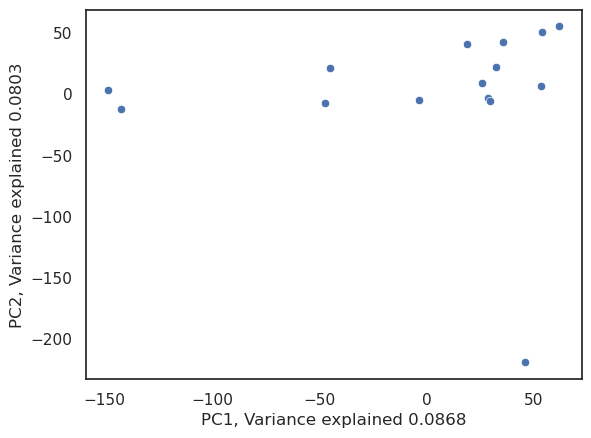

In [91]:
pcx = 0
pcy = 1
g =sns.scatterplot(x=pca10.sample_pca_projection[:,pcx], y=pca10.sample_pca_projection[:,pcy])
g.set(xlabel="PC1, Variance explained {0:.3g}".format(pca10.sample_pca_explained_variance_ratio[pcx].values),
      ylabel="PC2, Variance explained {0:.3g}".format(pca10.sample_pca_explained_variance_ratio[pcy].values))

In [92]:
pc_relate_matrix = sg.pc_relate(pca10, maf=0.1)["pc_relate_phi"].values

/home/eriks/miniconda3/envs/primatediversity2/lib/python3.12/site-packages/dask/array/core.py:3488: UserWarning: Passing an object to dask.array.from_array which is already a Dask collection. This can lead to unexpected behavior.
  warnings.warn(


<Axes: >

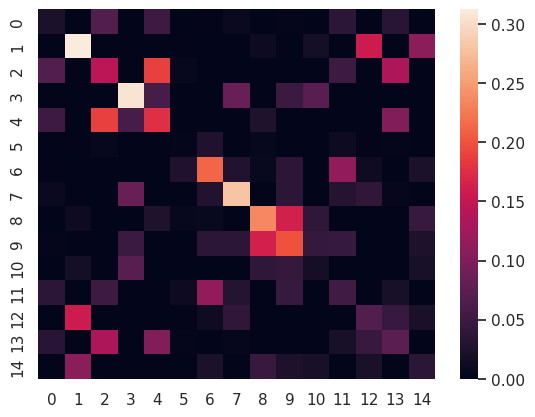

In [93]:
sns.heatmap(pc_relate_matrix.clip(min=0))
# Self should be 0.5, but is instead inferred to be 0.25-0.4 for the various individuals.

It should've calculated the self-kinship coefficient to be 0.5 on the diagonal, but instead it seems to be in the 0.25-0.4 ballpark.

In [94]:
ds_prep = pruned_ds.drop_dims(["windows"])
ds_prep["sample_cohort"] = xr.DataArray(range(len(ds_prep.sample_id)))
ds_prep = sg.window_by_genome(ds_prep)
fst_results = sg.Fst(ds_prep)
fst_results = fst_results["stat_Fst"].values
fst_results

array([[[        nan,  0.00583157,  0.01089053,  0.00193061,
          0.00997902,  0.10233176,  0.02023465,  0.00113276,
          0.0195122 ,  0.00131987,  0.0502803 ,  0.05766695,
          0.01309646,  0.00910558,  0.01240319],
        [ 0.00583157,         nan, -0.06469849, -0.06751534,
         -0.0657076 ,  0.03300254, -0.05922447, -0.08249555,
         -0.06226664, -0.06641453, -0.00381267, -0.02289722,
         -0.05084458, -0.04652221,  0.00601043],
        [ 0.01089053, -0.06469849,         nan, -0.06890289,
         -0.05341063,  0.03190693, -0.05772961, -0.07985139,
         -0.05990625, -0.06023069, -0.00585693, -0.00774532,
         -0.05523701, -0.04562199,  0.00221365],
        [ 0.00193061, -0.06751534, -0.06890289,         nan,
         -0.06657616,  0.02232478, -0.07214187, -0.07404481,
         -0.06402005, -0.07111111, -0.01037121, -0.02689008,
         -0.06415502, -0.05040402, -0.00294351],
        [ 0.00997902, -0.0657076 , -0.05341063, -0.06657616,
           

/home/eriks/miniconda3/envs/primatediversity2/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/eriks/miniconda3/envs/primatediversity2/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


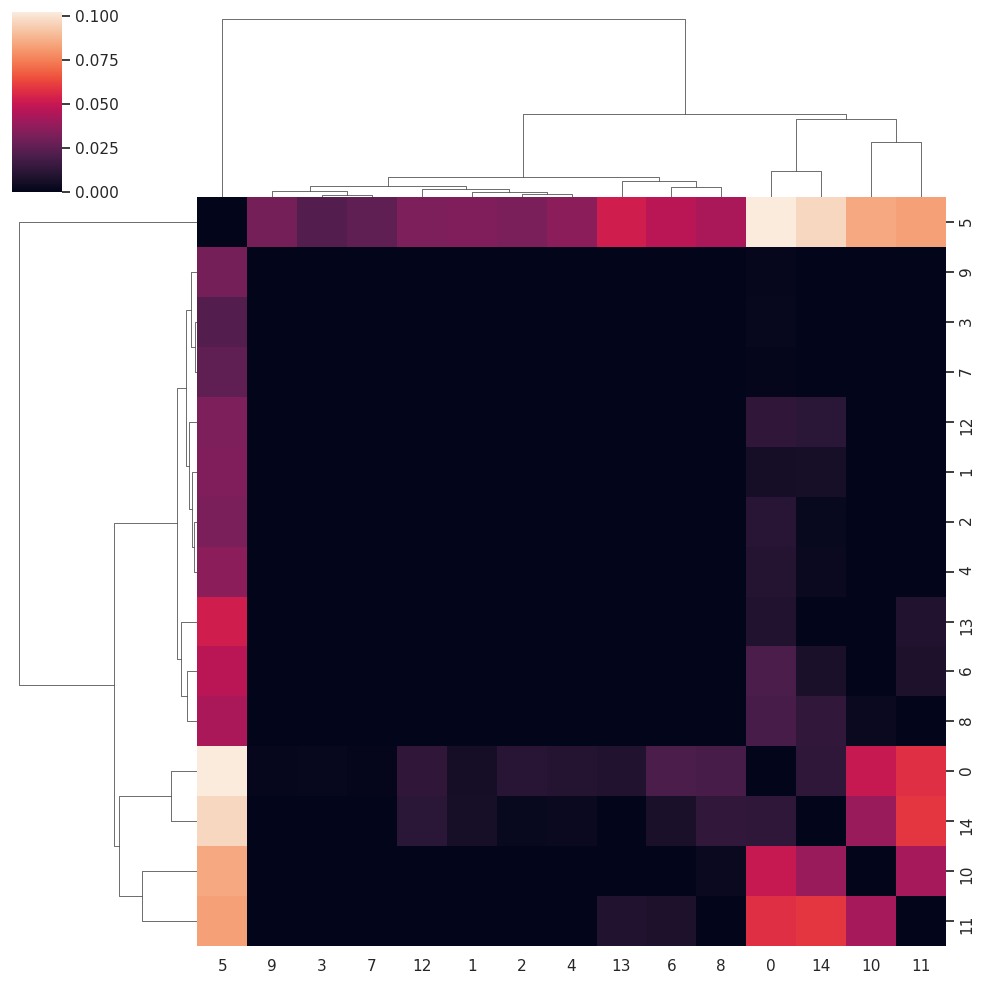

In [95]:
sns.clustermap(np.nan_to_num(fst_results)[0].clip(min=0))